In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
df = pd.read_csv('/content/drive/MyDrive/PLN_Timeseries/442100110323_15min_stationary.csv')
df['READ_DATE'] = pd.to_datetime(df['READ_DATE'])
df.set_index('READ_DATE', inplace=True)
df



,KWH_EXP_diff
READ_DATE,
2019-01-01 00:00:00,0.000353
2019-01-01 00:15:00,0.009907
2019-01-01 00:30:00,0.156262
2019-01-01 00:45:00,-0.068215
2019-01-01 01:00:00,-0.043631
...,...
2024-05-31 22:45:00,0.000000
2024-05-31 23:00:00,0.000000
2024-05-31 23:15:00,-0.358020


In [26]:
# split data train dan test. 3 tahun pertama untuk train, 2 tahun terakhir untuk test
train = df.loc['2019-01-01':'2022-12-31']
test = df.loc['2023-01-01':]

In [27]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [33]:
# jika datanya diambil setiap 15 menit, maka time_steps = 96 berarti 24 jam

time_steps = 96
# reshape ke bentuk 3D array
X_train, y_train = create_dataset(train, train['KWH_EXP'], time_steps)
X_test, y_test = create_dataset(test, test['KWH_EXP'], time_steps)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(122823, 96, 1) (122823,)
(43087, 96, 1) (43087,)


In [34]:
model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=1))

In [35]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 96, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
#  callback
# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')
# learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 2:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# training
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/10
3455/3455 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 2.5176 - val_loss: 1.3506 - learning_rate: 0.0010
Epoch 2/10
3455/3455 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 1.3191 - val_loss: 1.2219 - learning_rate: 0.0010
Epoch 3/10
3455/3455 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 1.2629 - val_loss: 0.7670 - learning_rate: 9.0484e-04
Epoch 4/10
3455/3455 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 1.2218 - val_loss: 0.6089 - learning_rate: 8.1873e-04
Epoch 5/10
3455/3455 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - loss: 1.2073 - val_loss: 0.5624 - learning_rate: 7.4082e-04
Epoch 6/10
3455/3455 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - loss: 1.1801 - val_loss: 0.5307 - learning_rate: 6.7032e-04
Epoch 7/10
3455/3455 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 1.1564 - val_loss: 0.5242 - learning_rate: 6.0653e-04
Epoch 8/10
3455/3455 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 1.1421 - val_loss: 0.5208 - learning_rate: 5.4881e-04
Epoch 9/10
3455/3455 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 

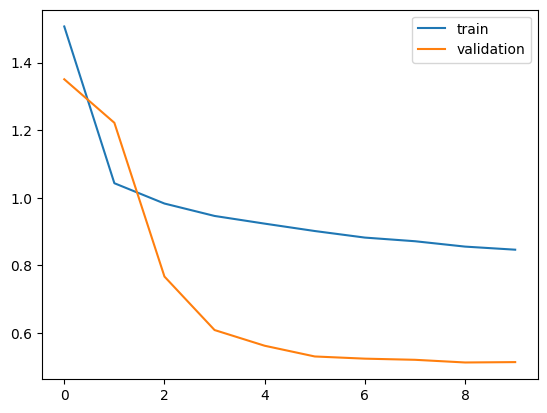

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [38]:
# predict

y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

1347/1347 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


In [39]:
# kembalikan data differencing ke bentuk semula
y_test = np.cumsum(y_test) + df['KWH_EXP'].iloc[time_steps]
y_pred = np.cumsum(y_pred) + df['KWH_EXP'].iloc[time_steps]

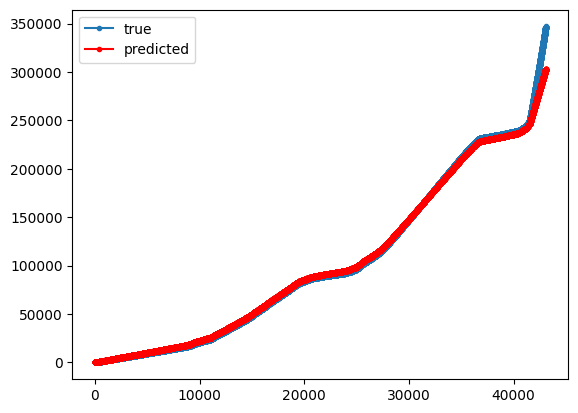

In [40]:
plt.plot(y_test, marker='.', label='true')
plt.plot(y_pred, 'r', marker='.', label='predicted')
plt.legend()
plt.show()


In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 26179836.158963203
MAE: 2422.526593171622
R2: 0.9965253165990802
MAPE: 0.041564281052641636
